# **Programming Assignment 2 : CNN**

*   Part: 1. MNIST classification using CNN
*   Part: 2. Visualizing the Convolutional Neural Network
*   Part: 3. Adverserial Examples

### MNIST classification using CNN

*Necessary Imports*

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import datetime

*Downloading and preparing the data*

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_validation_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_size = 50000
val_size = 10000

train_dataset, val_dataset = torch.utils.data.random_split(train_validation_dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, val_size, shuffle=False)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


print("length of training data: " , len(train_dataset))
print("length of validation data", len(val_dataset))

print("length of test data",len(test_dataset))

length of training data:  50000
length of validation data 10000
length of test data 10000


### Question: Build a simple network to classify MNIST data

*The Network class*

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=1, stride = 1)
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1, stride = 1)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        self.fc1 = nn.Linear(7 * 7 * 64,500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x


*Function for training the network*

In [12]:
def train(net, epochs, log_interval):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  train_loss = []
  validation_loss = []
  pred_acc = []


  start_time = datetime.datetime.now()
  print("start_time: ", start_time)


  # Training loop
  for epoch in range(epochs):  # Loop over the dataset multiple times
      running_loss = 0.0
      batch_id = 0
      for inputs, labels in trainloader:

        batch_id += 1
        loss_train = 0
        loss_validation = 0
        acc = 0

        with torch.set_grad_enabled(True):
          optimizer.zero_grad()  # Zero the parameter gradients
          # Forward pass
          outputs = net(inputs)
          _, predicted = torch.max(outputs, 1)
          correct = (predicted == labels).sum().item() * 100 / len(predicted)
          loss = criterion(outputs, labels)
          pred_acc.append(correct)


          # Backpropagation and optimization
          loss.backward()
          optimizer.step()


        with torch.set_grad_enabled(False):
          for inputs_validation, labels_validation in valloader:
            outputs_validation = net(inputs_validation)
            loss_validation = criterion(outputs_validation, labels_validation)

          if(batch_id%log_interval   == 0):

            validation_loss.append(loss_validation.item() * 100/ len(inputs_validation))
            train_loss.append(loss.item() * 100 / len(inputs))


      #print(f"Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}")


  print("Finished Training")
  end_time = datetime.datetime.now()
  print("end_time: ", end_time)
  print("time elapsed: ", end_time - start_time)

  return (train_loss, validation_loss, pred_acc)


*Function for testing the network*

In [8]:
def test(net):
  # Test the model on the test data
  correct = 0
  total = 0

  with torch.no_grad():
      for data in testloader:
          images, labels = data
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f"Average accuracy on test data: {100 * correct / total}%")
  return predicted

### 1. Show the plot of training error, validation error and prediction accuracy as the training progresses. At the end of training, report the average prediction accuracy for the whole test set of 10000 images.

start_time:  2023-10-03 15:13:03.824399
Finished Training
end_time:  2023-10-03 16:23:02.783154
time elapsed:  1:09:58.958755


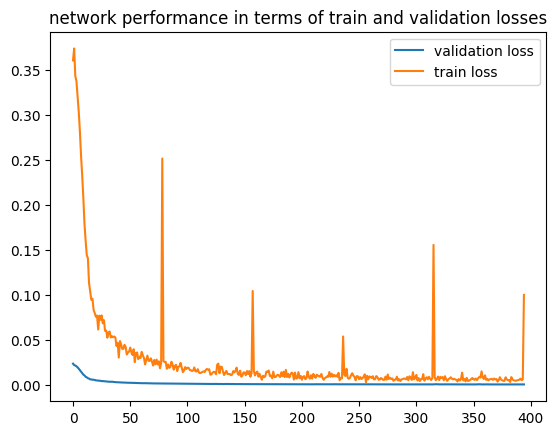

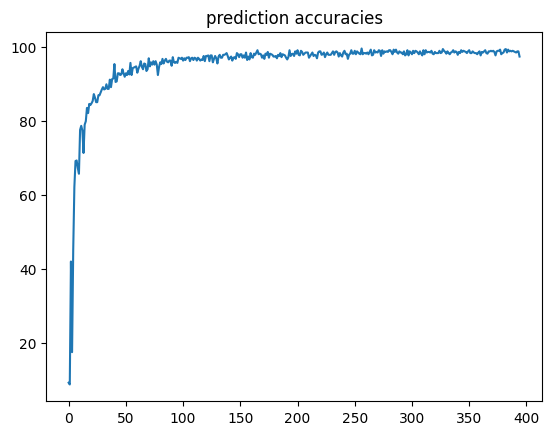

Average accuracy on test data: 98.65%


In [11]:
net = Net()
(train_loss, validation_loss, pred_acc) = train(net, 15, 100)

#plotting relevant statistics
plt.title("network performance in terms of train and validation losses")
plt.plot(validation_loss, label = "validation loss")
plt.plot(train_loss, label = "train loss")
plt.legend()
plt.show()

plt.title("prediction accuracies")
plt.plot(pred_acc, label = "prediction accuracies while training")
plt.show()

predicted = test(net)

### 2. Plot randomly selected test images showing the true and predicted class labels

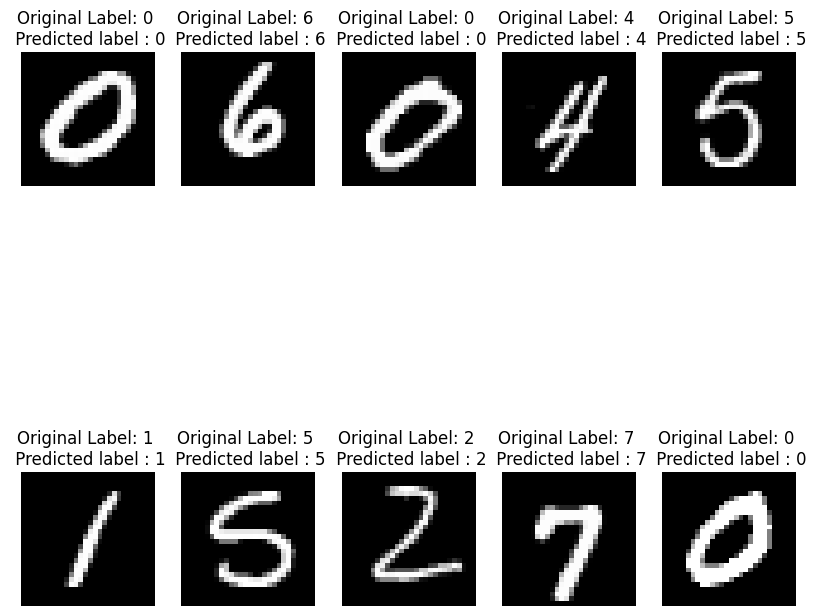

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your own data)
random_set = set(np.random.randint(0, len(test_dataset), 10))
images = [testloader.dataset[index][0] for index in random_set]  # List of 16 random 28x28 images
labels = [testloader.dataset[index][1] for index in random_set]  # List of 16 corresponding labels
predicted = [torch.argmax(net(image)) for image in images]

# Create a grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

# Iterate over the images and labels and plot them in the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i][0], cmap='gray')  # Display the image
    ax.set_title(f"Original Label: {labels[i]} \n Predicted label : {predicted[i]}")  # Set the title as the label
    ax.axis('off')  # Turn off axis labels

plt.show()



### 3. Report the dimensions of the input and output at each layer.

In [14]:
dummy_input = torch.randn(1, 28, 28)
dummy_input = net.conv1(dummy_input)
print(f"conv1 output dimension: {dummy_input.shape[0]} channels, {dummy_input.shape[1]} height, {dummy_input.shape[2]} width")
dummy_input = net.pool1(dummy_input)
print(f"pool1 output dimension: {dummy_input.shape[0]} channels, {dummy_input.shape[1]} height, {dummy_input.shape[2]} width")
dummy_input = net.conv2(dummy_input)
print(f"conv2 output dimension: {dummy_input.shape[0]} channels, {dummy_input.shape[1]} height, {dummy_input.shape[2]} width")
dummy_input = net.pool2(dummy_input)
print(f"pool2 output dimension: {dummy_input.shape[0]} channels, {dummy_input.shape[1]} height, {dummy_input.shape[2]} width")

dummy_input = dummy_input.view(-1, 7 * 7  * 64)

dummy_input = net.fc1(dummy_input)
print(f"fc1 output dimension: {dummy_input.shape[1]}")
dummy_input = net.fc2(dummy_input)
print(f"fc2 output dimension: {dummy_input.shape[1]}")

conv1 output dimension: 32 channels, 28 height, 28 width
pool1 output dimension: 32 channels, 14 height, 14 width
conv2 output dimension: 64 channels, 14 height, 14 width
pool2 output dimension: 64 channels, 7 height, 7 width
fc1 output dimension: 500
fc2 output dimension: 10


### 4. How many parameters does your network have? How many of thes are in the fully connected layers and how many are in the convolutional layers?

In [15]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(f"Layer: {name}, Parameters: {param.numel()}")

Layer: conv1.weight, Parameters: 288
Layer: conv1.bias, Parameters: 32
Layer: conv2.weight, Parameters: 18432
Layer: conv2.bias, Parameters: 64
Layer: fc1.weight, Parameters: 1568000
Layer: fc1.bias, Parameters: 500
Layer: fc2.weight, Parameters: 5000
Layer: fc2.bias, Parameters: 10


### 5. How many neurons does your network have? How many of these are in the fully connected layers and how many are in the convolutional layers?

In [16]:
# Iterate through the layers and print the number of neurons
input_height = 28
input_width = 28

for name, layer in net.named_modules():
    if isinstance(layer, nn.Conv2d):
        in_channels = layer.in_channels
        out_channels = layer.out_channels
        kernel_size = layer.kernel_size
        padding = layer.padding
        stride = layer.stride

        output_height = (input_height + 2 * padding[0] - kernel_size[0])/stride[0] + 1
        output_width = (input_width + 2 * padding[0] - kernel_size[1])/stride[0] + 1

        input_height = output_height
        input_width = output_width

        neurons = out_channels * output_height * output_width

        print(f"Convolution Layer: {name}, Neurons: {neurons}")

    if isinstance(layer, nn.MaxPool2d):

      kernel_size = layer.kernel_size
      padding = layer.padding
      stride = layer.stride

      output_height = (input_height + 2 * padding - kernel_size[0])/stride + 1
      output_width = (input_width + 2 * padding - kernel_size[1])/stride + 1

      input_height = output_height
      input_width = output_width


    elif isinstance(layer, nn.Linear):
        out_features = layer.out_features
        neurons = out_features
        print(f"Fully Connected Layer: {name}, Neurons: {neurons}")

Convolution Layer: conv1, Neurons: 25088.0
Convolution Layer: conv2, Neurons: 12544.0
Fully Connected Layer: fc1, Neurons: 500
Fully Connected Layer: fc2, Neurons: 10


###6. Use batch-normalization. Does it improve the test accuracy? Does it affect training time?

In [17]:
# Define a simple CNN model with batch normalization
class NetWithBatchNorm(nn.Module):
    def __init__(self):
        super(NetWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = (3, 3), padding=1, stride = 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size = (3, 3), padding=1, stride = 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)

        self.fc1 = nn.Linear(7 * 7 * 64,500)
        self.bn3 = nn.BatchNorm1d(500)

        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 7 * 7 * 64)
        x = self.fc1(x)
        x = self.bn3(x)

        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Instantiate the model
model = NetWithBatchNorm()

# Print the model architecture
print(model)


NetWithBatchNorm(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=500, bias=True)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [18]:
nbn = NetWithBatchNorm()
(train_loss, validation_loss, pred_acc) = train(nbn, 1, 1)
predicted = test(nbn)

start_time:  2023-10-03 16:34:56.454670
Finished Training
end_time:  2023-10-03 16:52:53.113744
time elapsed:  0:17:56.659074
Average accuracy on test data: 98.66%


Observation: Batch Normalization indeed improves test accuracy. Also it does not affet the training time significantly.

###Question: Visualizing the Convolutional Neural Network

### 1. Plot the the conv1 layer filters. Do you observe interesting patterns?

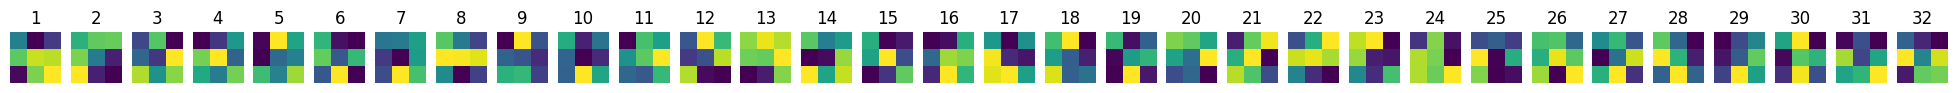

In [19]:
# Access the weights of the conv1 layer
conv1_weights = net.conv1.weight.data

# Plot the filters
num_filters = conv1_weights.size(0)
fig, axs = plt.subplots(1, num_filters, figsize=(25, 25))

for i in range(num_filters):
    filter_i = conv1_weights[i].cpu().numpy()
    axs[i].imshow(filter_i[0])
    axs[i].axis('off')
    axs[i].set_title(f'{i+1}')

plt.show()

Interesting Patters:
  The weights that the network has learnt depicts the strokes that are most commonly observed in handwritten digits. Because of that the layer 1 activations are expected to look much like the figure itself mostly. It appears that if I want to construct any digit with the layer 1 weights, I can possibly do so, because it closely captures all major stroke patterns in a segmented manner. In short, the layer 1 weights explains the local spacial features very well.

### 2. Plot filters of a higher layer and compare them with conv1 layer filters.

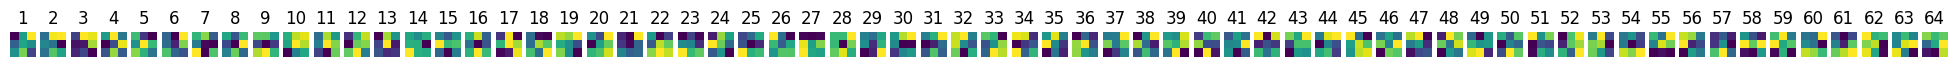

In [20]:
conv2_weights = net.conv2.weight.data

# Plot the filters
num_filters = conv2_weights.size(0)
fig, axs = plt.subplots(1, num_filters, figsize=(25, 25))

for i in range(num_filters):
    filter_i = conv2_weights[i].cpu().numpy()
    axs[i].imshow(filter_i[0])  # Assuming single-channel filters
    axs[i].axis('off')
    axs[i].set_title(f'{i+1}')

plt.show()

Observation:
  These weights does not depicts any similar correspondence with first layer weights as well as the original data. Reason being it descrives more global features involving larger spacial location in a compact manner.

### 3. Visualize the activations of the convolutional layers. What do you observe as you go deeper?

In [21]:
#defining a function to visualize the convolutional layers
def visualize(data, rows, cols, layer):
  #visualizing the activations of the first convolution layer
  print(layer, " activations")
  fig, axs = plt.subplots(rows, cols, figsize=(15, 15))

  for i in range(rows):
    for j in range(cols):
      ax = axs[i, j]
      ax.imshow(data[i * cols + j].detach().numpy())
      ax.axis('off')
  plt.show()

original image


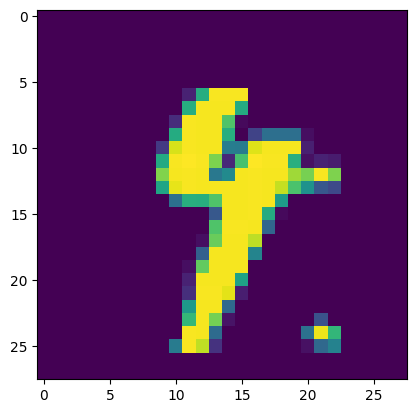

32
conv1  activations


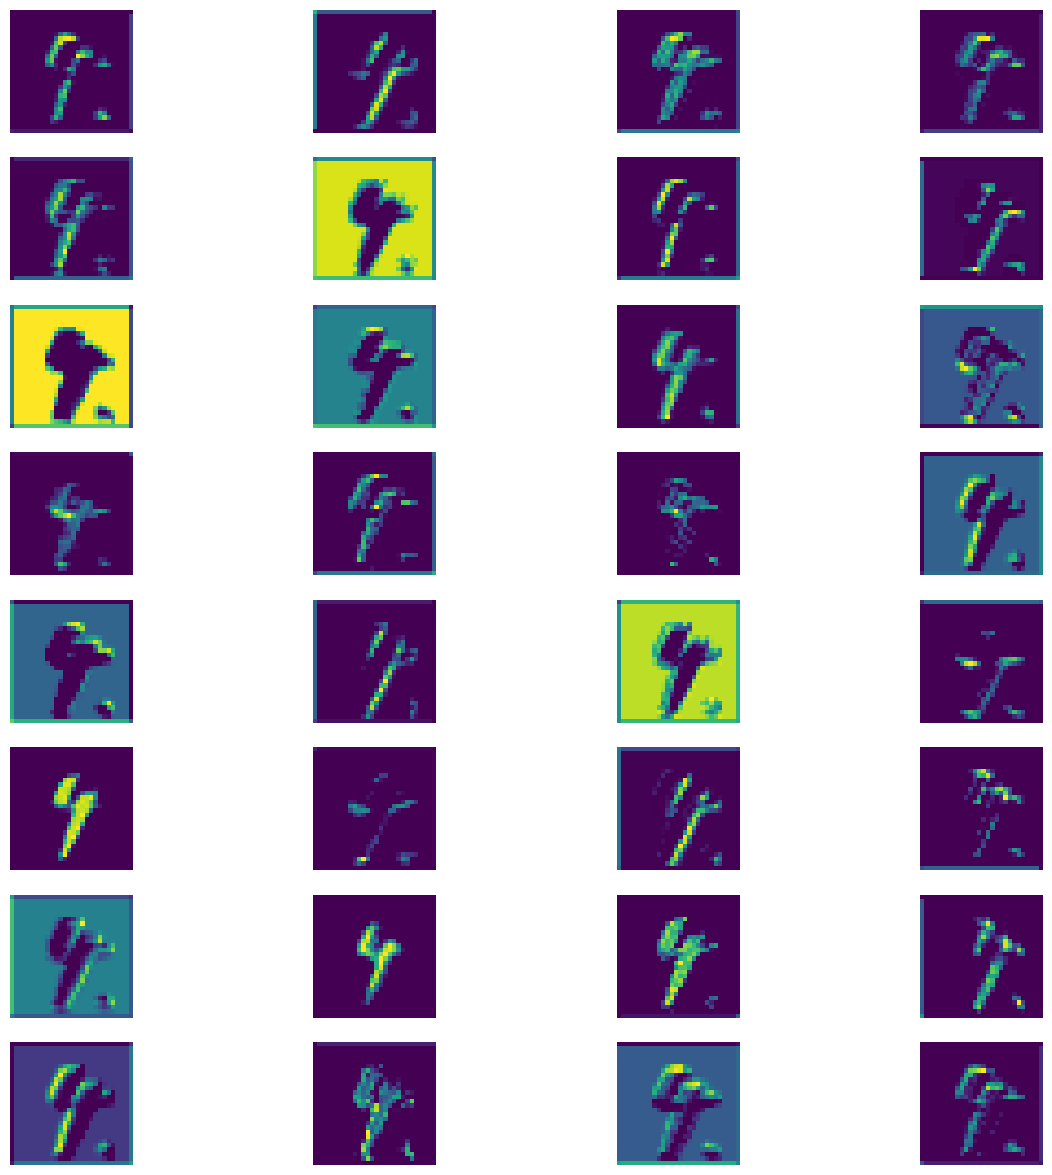

cov2  activations


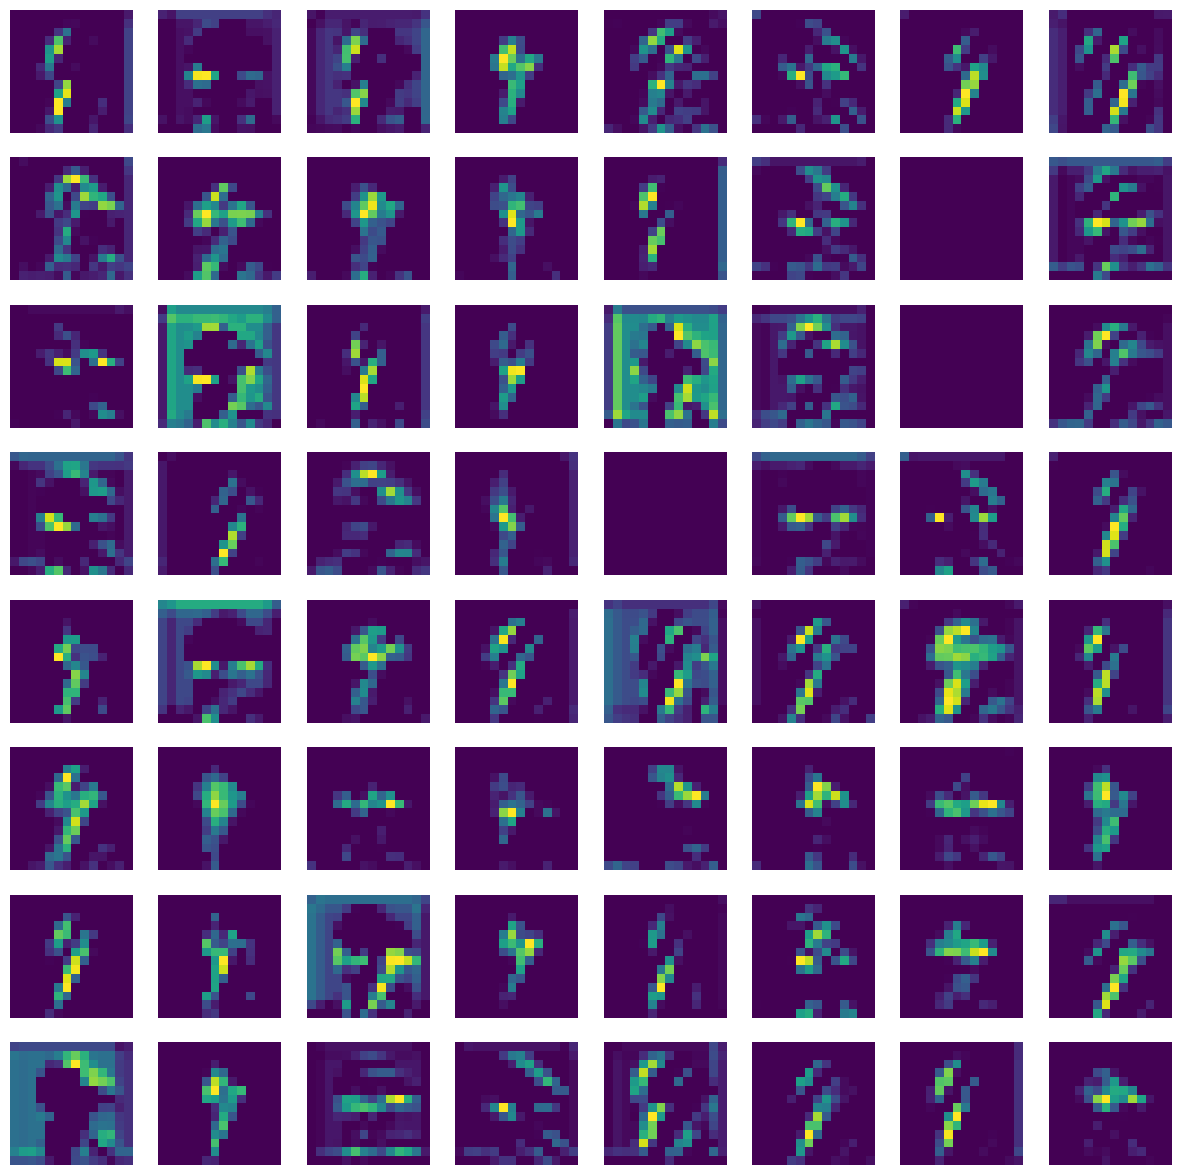

In [22]:

data = trainloader.dataset[0][0]

#visualizing the original image
print("original image")
plt.imshow(data[0].detach().numpy())
plt.show()

#visualizing the activations of the first convolutional layer

#get the activation of the convolutional layer 1
#step 1: propagate the original image
data = torch.relu(net.conv1(data))
#step 2: splitting over rows and columns

rows = 8
cols = int(data.shape[0]/rows)
print(data.shape[0])

#step 3: visualize the result
visualize(data, rows, cols, "conv1")


#visualizing the activations of the second convolution layer
data = net.pool1(data)
data = torch.relu(net.conv2(data))

rows = 8
cols = int(data.shape[0]/rows)

visualize(data, rows, cols, "cov2")


### 4. Occluding parts of the image

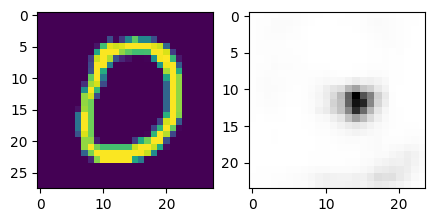

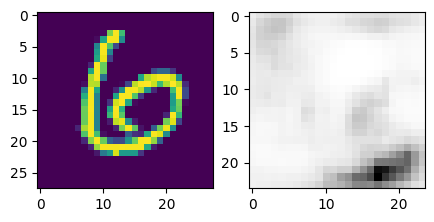

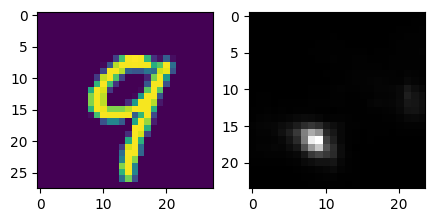

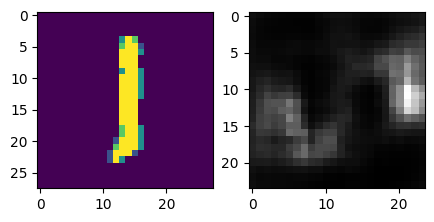

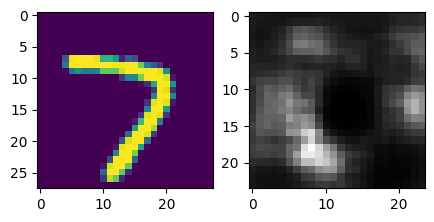

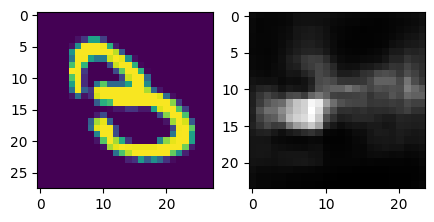

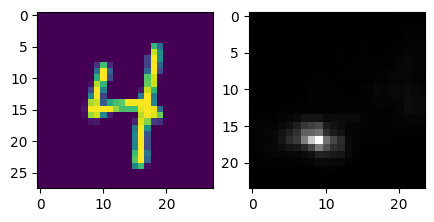

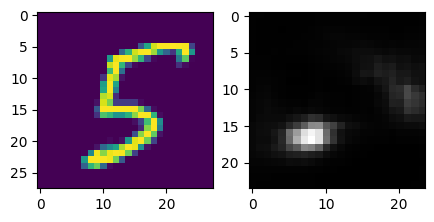

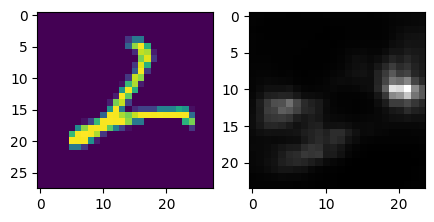

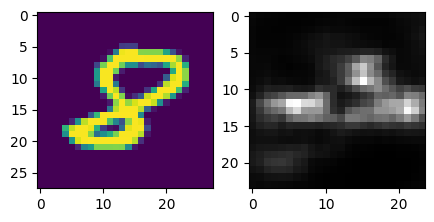

In [23]:
#handpicked some data that are correctly classified
index = [10, 11, 12, 14, 17, 18, 19, 23, 43, 61]

for i in index:
  input_image = testloader.dataset[i][0]

  # Define the occlusion window size (5x5)
  occlusion_size = 5

  # Get the input image dimensions
  image_height, image_width = input_image[0].shape[-2], input_image[0].shape[-1]

  # Initialize a matrix to store the predictions for each occluded region
  num_regions = (image_height - occlusion_size + 1) * (image_width - occlusion_size + 1)
  predictions_matrix = np.zeros(((image_height - occlusion_size + 1), (image_width - occlusion_size + 1)))

  # Slide the occlusion window across the image

  for y in range(image_height - occlusion_size + 1):
      for x in range(image_width - occlusion_size + 1):
          # Create a copy of the input image and occlude the region
          occluded_image = input_image.clone()
          occluded_image[0, y:y+occlusion_size, x:x+occlusion_size] = 0.5

          # Get predictions for the occluded image
          with torch.no_grad():
              predictions = net(occluded_image)

          # Store the predictions in the matrix
          predictions_matrix[y][x] = torch.sigmoid(predictions).cpu().numpy()[0][testloader.dataset[index[0]][1]]


  fig, axs = plt.subplots(1, 2, figsize=(5, 5))
  axs[0].imshow(input_image[0])
  axs[1].imshow(predictions_matrix, cmap = "gray")
  plt.show()



Observation:
The lighter areas correspond to those, blocking which leads to significat drop of accuracy. With this invariant, it can be stated that it learns to identify the significant areas from any handwritten digit, and also blocking areas that do not contain the strokes still obtains higher performance accuracy.
For classes such as 3 or 8, much of the portion is found as white means those are very sensitive and it can also be assummed that the samples also varies which covers those areas.

# Question 3: Adversarial Examples

In [24]:
def adverserial_non_targetted_attack(random_image, net, epsilon, epochs, out):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  train_loss = []

  for epoch in range(epochs):
    with torch.set_grad_enabled(True):
      optimizer.zero_grad()
      random_image.requires_grad = True

      output = net(random_image)

      loss = criterion(output, out)
      loss.backward()
      data_grad = random_image.grad.data

      train_loss.append(loss.item())

      random_image = torch.subtract(random_image, epsilon * data_grad).clone().detach()

  return ( train_loss ,random_image )



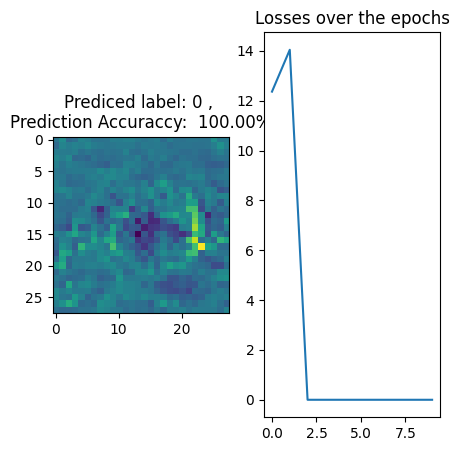

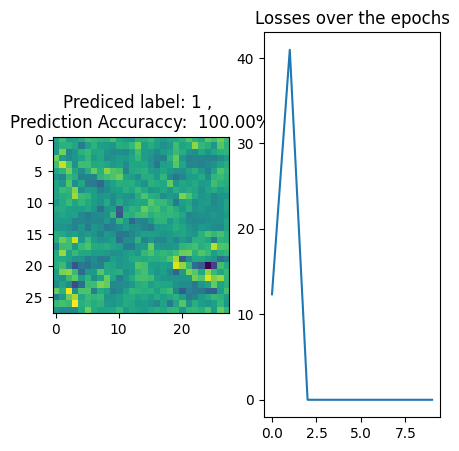

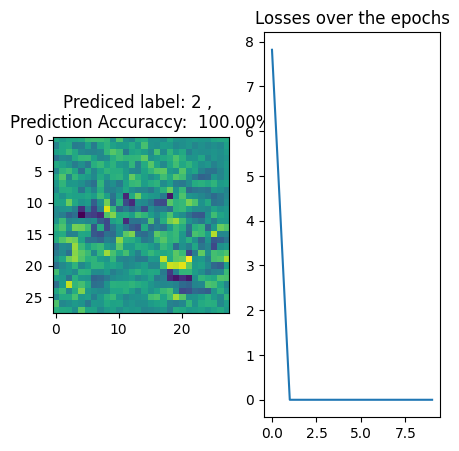

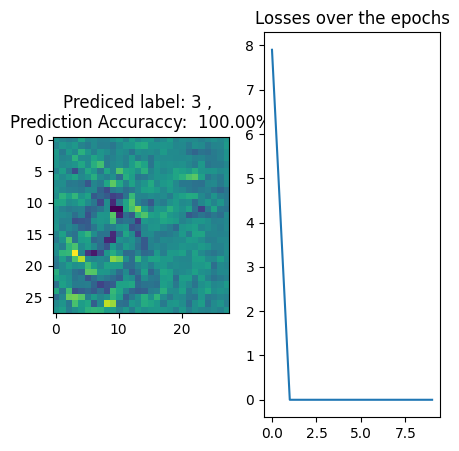

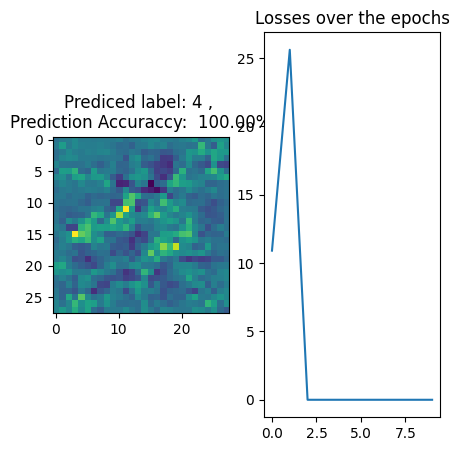

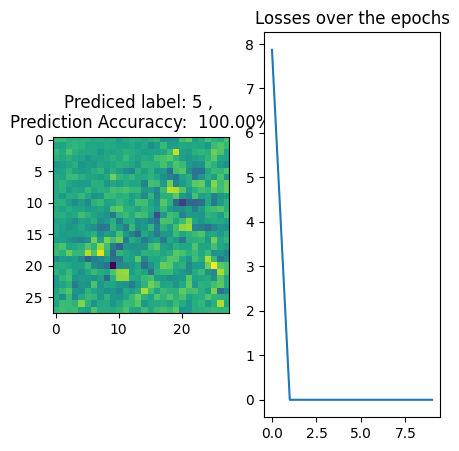

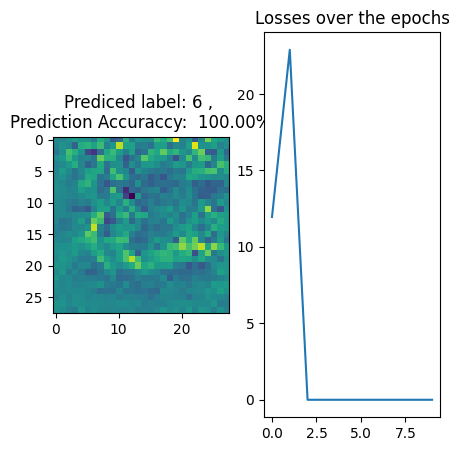

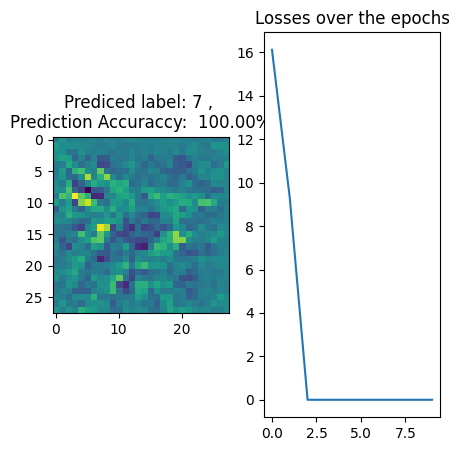

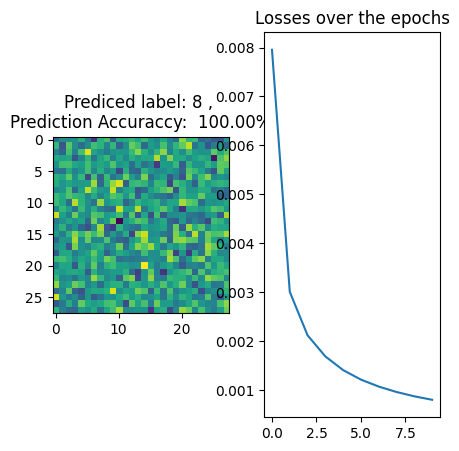

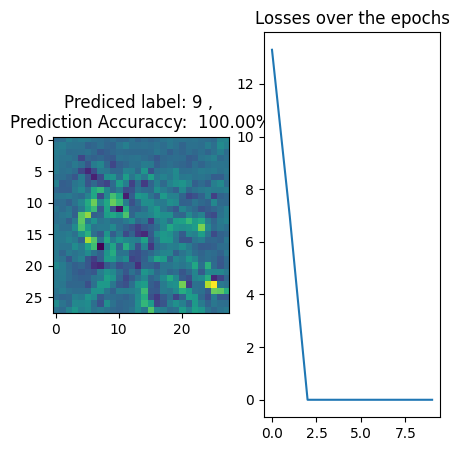

In [25]:
generated_images = []
losses = [i for i in range(10)]

for out in range(10):
  random_image = torch.normal(mean=0.5, std = 0.5, size=(1, 28, 28))
  (loss, generated_image) = adverserial_non_targetted_attack(random_image, net, 1e1, 10, torch.tensor([out]))
  losses.append(loss)

  output = net(generated_image)
  prediction,_ = torch.max(torch.sigmoid(output), 1)

  generated_images.append(generated_image)


  # Create a grid of subplots

  fig, axes = plt.subplots(1, 2, figsize=(5, 5))

  axes[0].imshow(generated_image[0])
  axes[0].set_title(f"Prediced label: {out} , \nPrediction Accuraccy: {prediction[0] * 100 : .2f}%")
  axes[1].set_title("Losses over the epochs")
  axes[1].plot(loss)

  plt.show()

Observation:
The generated images does not look even close to the original images and with an adequate learning rate the loss with respect to the target classes decreases pretty quickly.
The possible reason: Since the [28*28] space in real dimension is so huge and amongst all the space the representable images capture relatively such a tiny subspace that the boundary our network learns also contains a very huge amount of noise/unrepresentable image kind of data. And with this attack we reach to such an image with ease which falls under our target class boundary and therefore leads to a high acccuracy of it to get classified as one of the possible classes.

### 3.2 Targeted Attack

In [26]:
def adverserial_targetted_attack(random_image, targetData, net, epsilon, beta, epochs, out):

  criterionCrossEntropy = nn.CrossEntropyLoss()
  criterionMSE = nn.MSELoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  train_loss = []

  for epoch in range(epochs):
    with torch.set_grad_enabled(True):
      optimizer.zero_grad()
      random_image.requires_grad = True

      output = net(random_image)

      loss = criterionCrossEntropy(output, out) + beta * criterionMSE(targetData, random_image)
      loss.backward()
      data_grad = random_image.grad.data

      train_loss.append(loss.item())

      random_image = torch.subtract(random_image, epsilon * data_grad).clone().detach()

  return ( train_loss ,random_image )



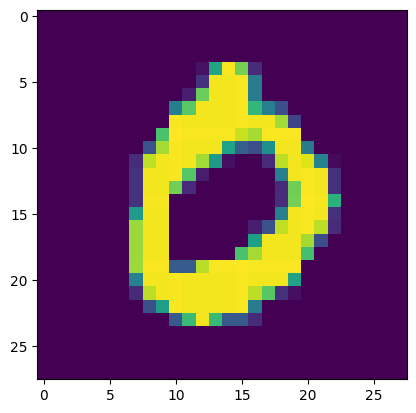

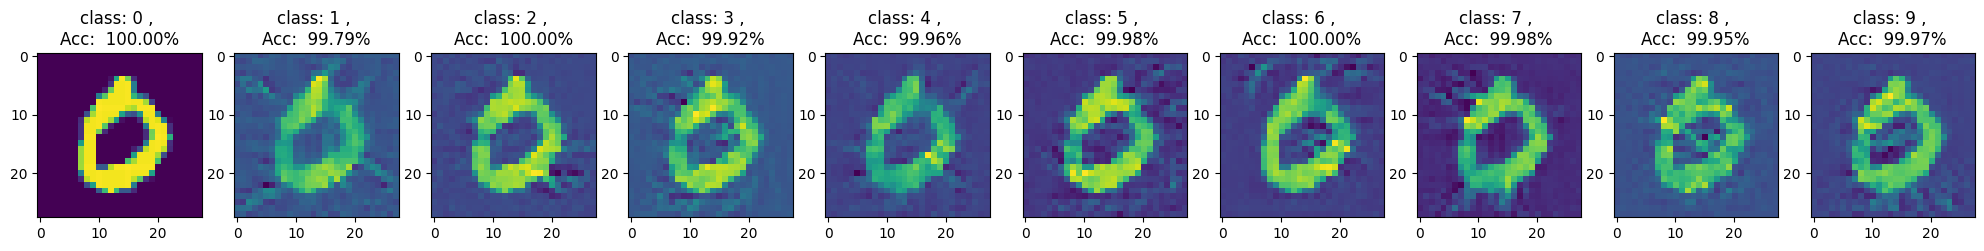

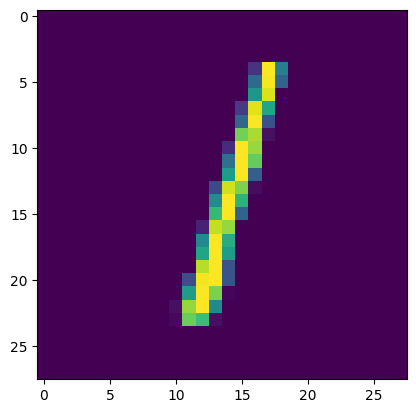

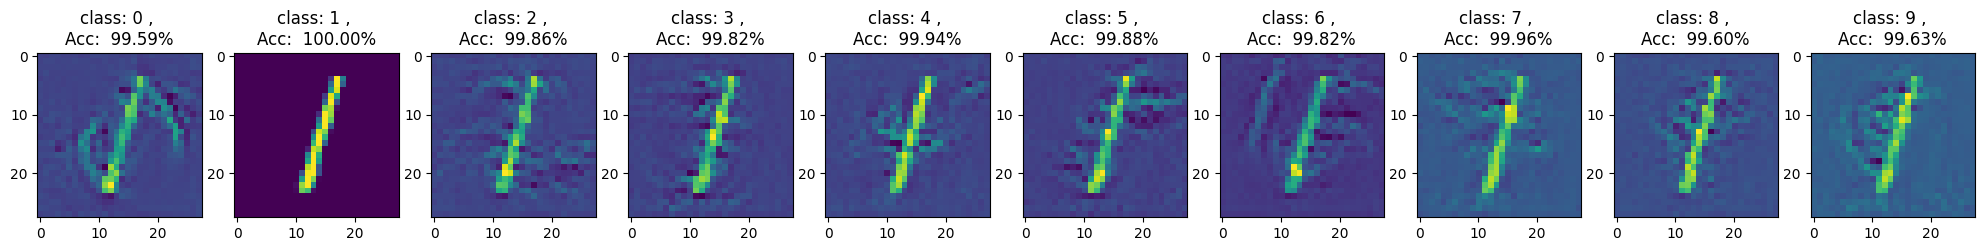

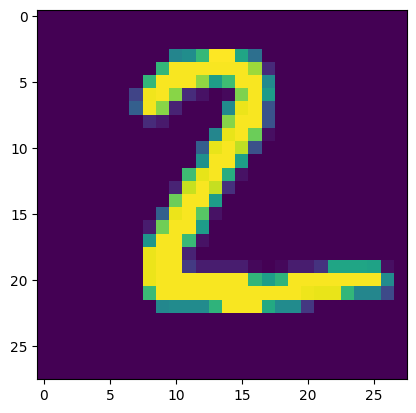

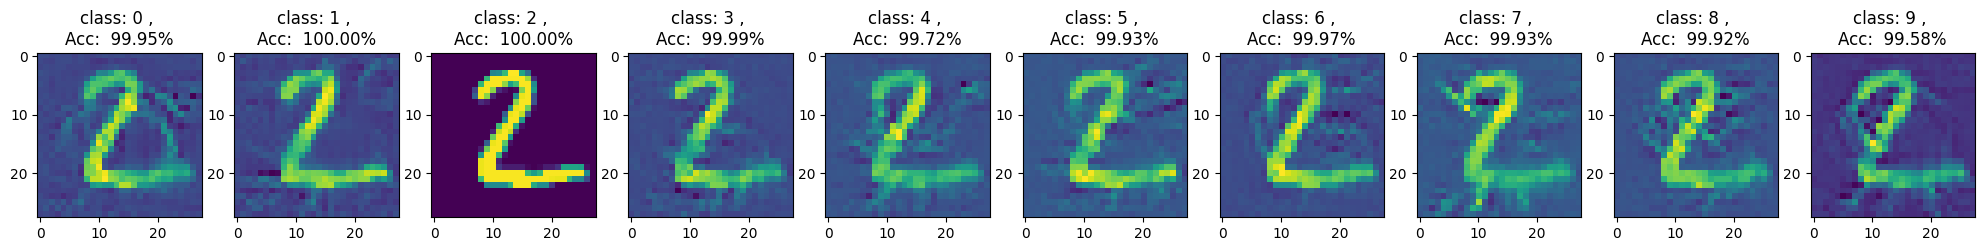

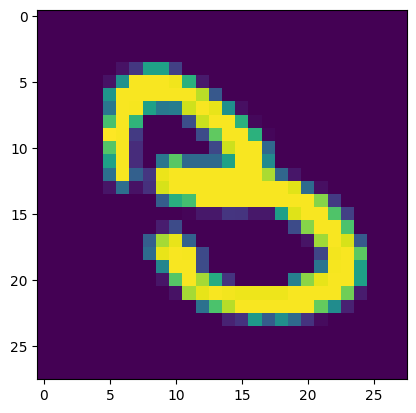

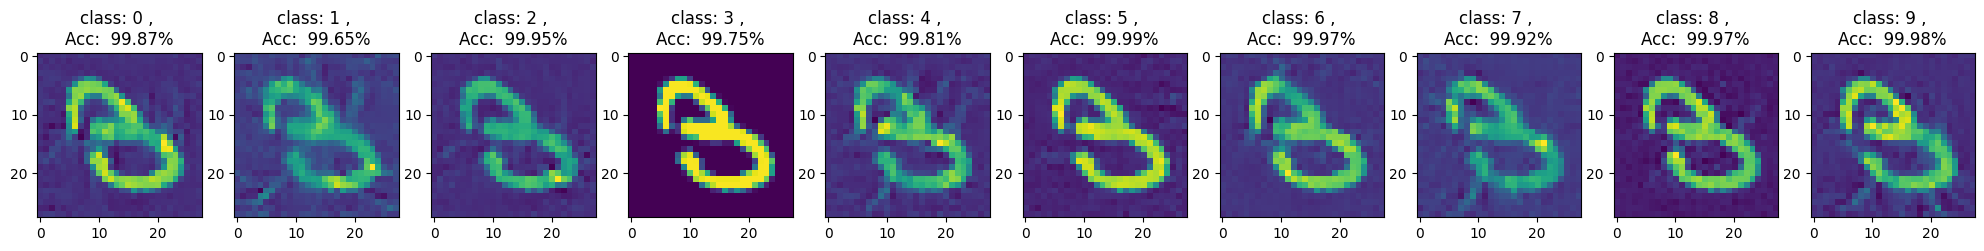

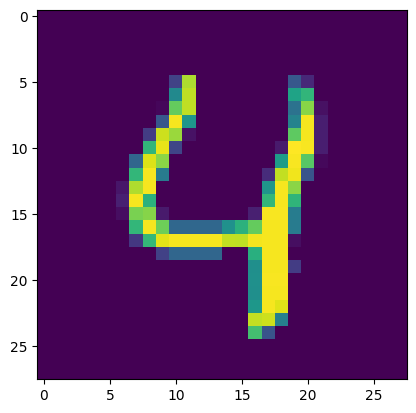

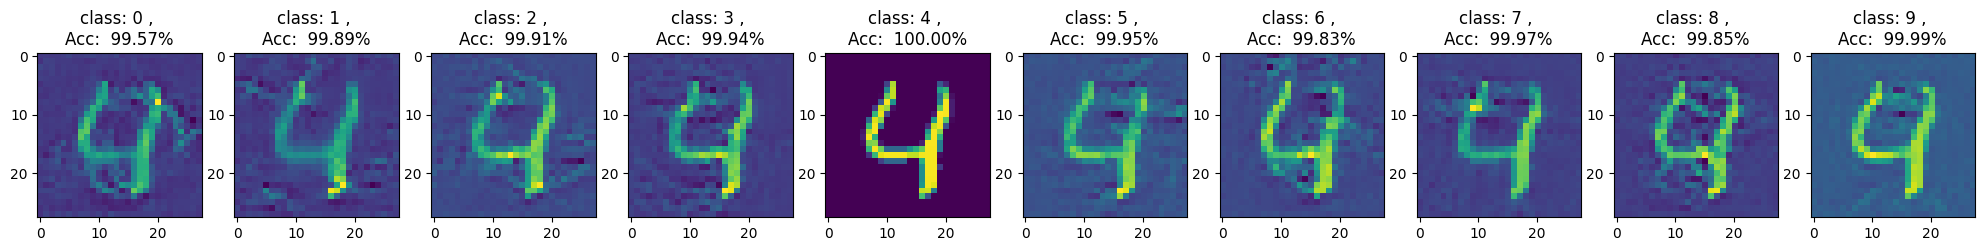

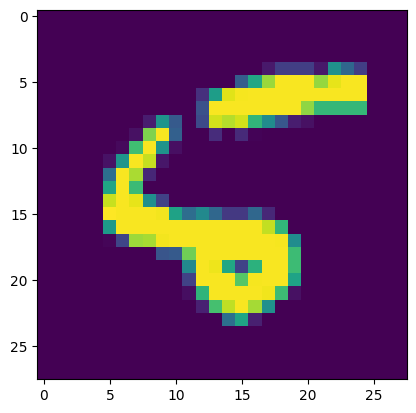

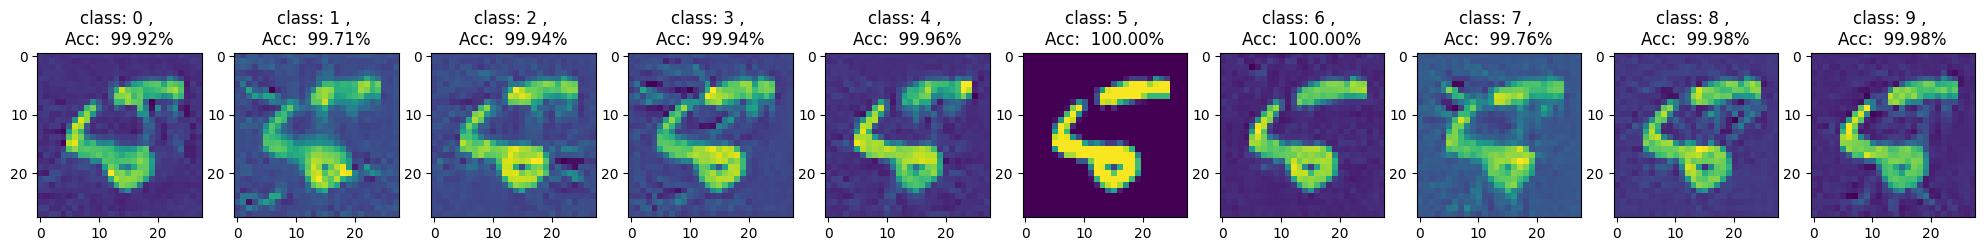

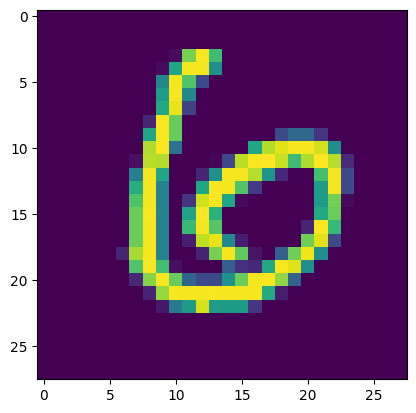

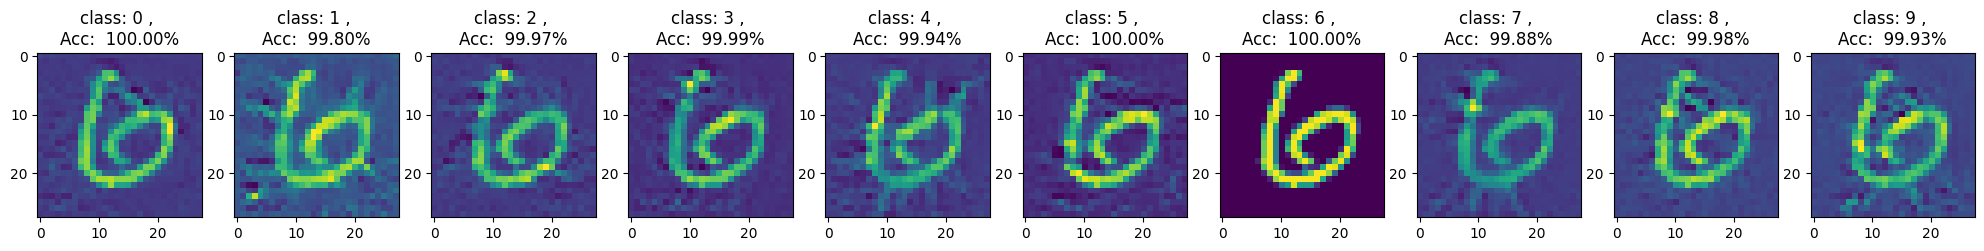

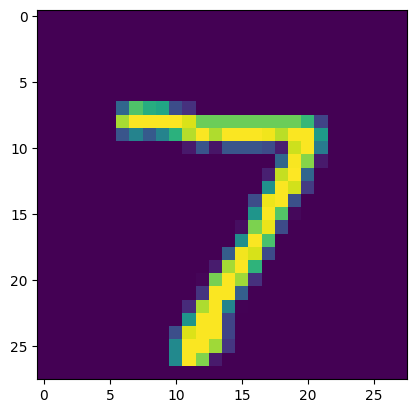

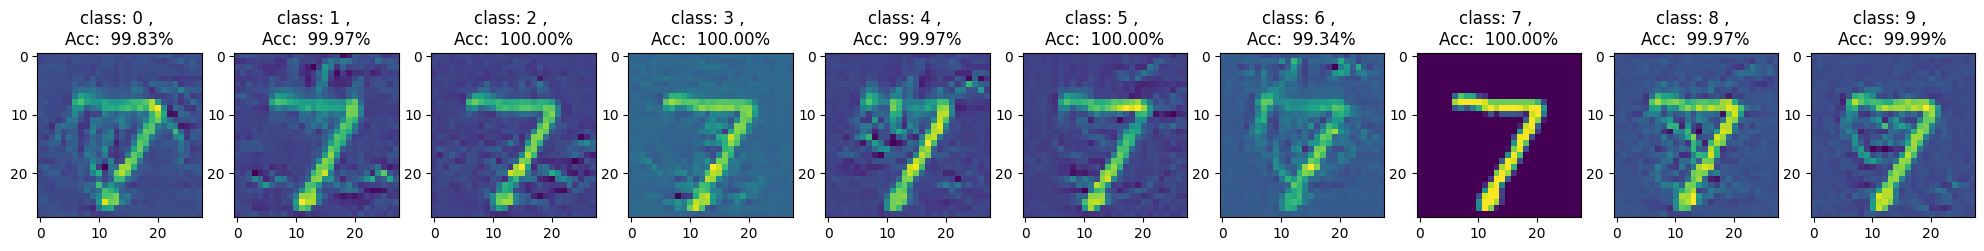

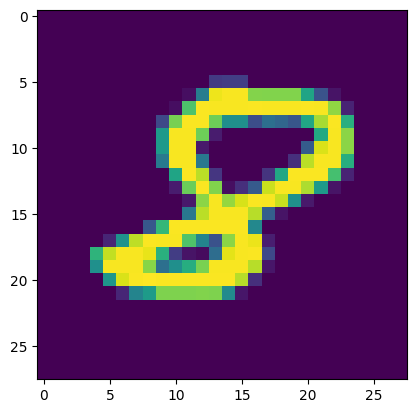

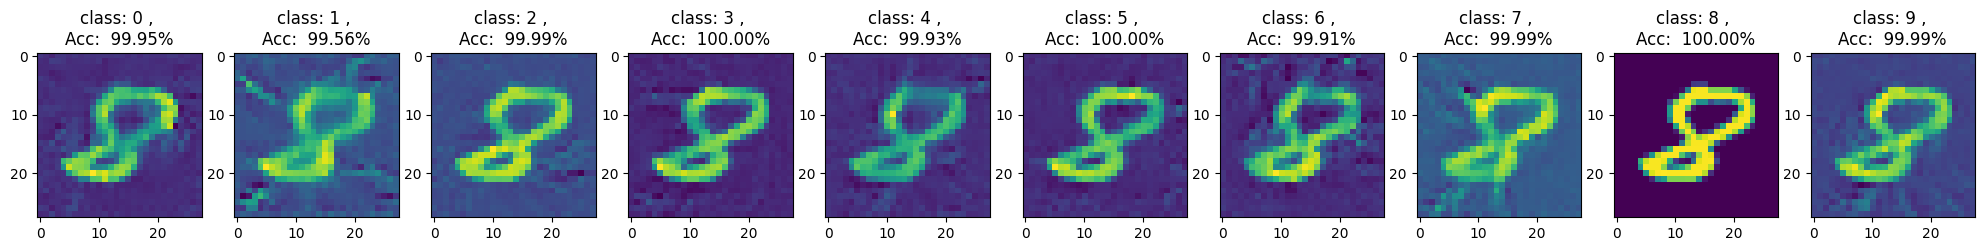

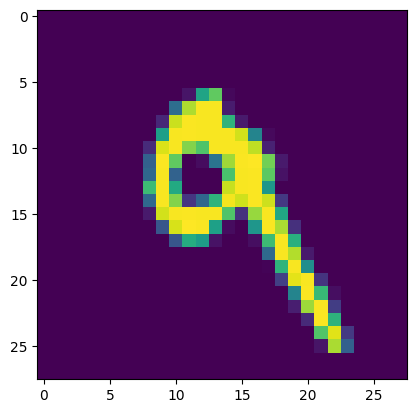

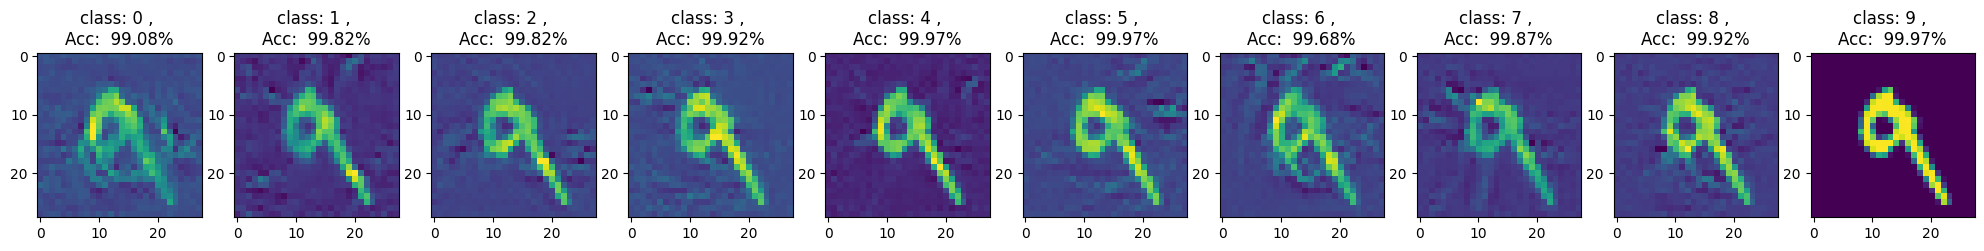

In [27]:
#def perform_targetted_attack(label):
for l in range(10):

  dataset = testloader.dataset

  # Get the indices of samples belonging to class 0
  indices = [idx for idx, (_, label) in enumerate(dataset) if label == l]
  #loader = torch.utils.data.DataLoader(dataset, batch_size=len(indices) ,sampler=torch.utils.data.sampler.SubsetSampler(indices))


  outputs = []

  for index in indices:
    net.eval()
    with torch.set_grad_enabled(False):
      output = net(testloader.dataset[index][0])
      output = torch.sigmoid(output)[:, 0]

  index = indices[np.argmax(output)]
  targetData = testloader.dataset[index][0]

  plt.imshow(targetData[0])

  accuracies = []
  generated_images = []

  fig, axes = plt.subplots(1, 10, figsize=(25, 25))

  for t in range(10):
    if(t != l):
      random_image = torch.normal(mean=0.5, std = 0.5, size=(1, 28, 28))
      (loss, generated_image) = adverserial_targetted_attack(random_image, targetData, net, 1, 10, 100, torch.tensor([t]))
      losses.append(loss)
      generated_images.append(generated_image)

      output = net(generated_image)
      prediction = torch.sigmoid(output)[0][t]

      axes[t].imshow(generated_image[0])
      axes[t].set_title(f"class: {t} , \nAcc: {prediction * 100 : .2f}%")


    else:

      output = net(targetData)
      prediction = torch.sigmoid(output)[0][t]

      axes[t].imshow(targetData[0])
      axes[t].set_title(f"class: {t} , \nAcc: {prediction * 100 : .2f}%")

  plt.show()






Observation: Here in the plotted images, accuracies has been presented with corresponding to the respective classes in order, it is very prevalent that the generated image looks much like the target number and it is possible to fool the network with such kind of image.